# A Gentle Introduction to Natural Language Process
Today, we will take a text, *War and Peace* by Leo Tolstoy, and try to get verify or refute the claims of an outside source, *Tolstoy's Phoenix: From Method to Meaning in War and Peace* by George R. Clay (1998). This is a very common task both in and outside of the digital humanities and will introduce you to the popular NLP Python package, the Natural Language Toolkit (NLTK), and expose you to common methodologies for wrangling textual data.   

## Our overall task

We will start by downloading the book and then we will learn how to clean the text, perform basic statistics, create visualizations, and discuss what we found and how to present those results

## Goals
* Understand the rights we have to access books on Project Gutenberg
* Read in a text from Project Gutenberg
* Clean textual data using regular expressions
* Perform basic word frequency statistics
* Create visualziations of these statistics 
* Discuss how to communicte thses results
* Return to our research question

## General methods

### Read in our data
We will start with a url from Project Gutenberg. All of the texts from Gutenberg are in the public domain, so we won't have to worry about rights, but be aware of who own the intellectual property to a text before you scrape it. In this section, we will break the text up by chapter division. Later we'll do the same but by book division. 

#### The requests library
Here, we are using a library called `requests`. This library is great for HTTP requests, which are like asking for a specific action from the internet. 

More details below:
https://pypi.org/project/requests/

In [ ]:
import requests
url = 'https://www.gutenberg.org/cache/epub/2600/pg2600.txt'
text = requests.get(url).text

In [ ]:
## IMPORTANT: this pipeline will work for all text, but you will need to understand your text
## There is no one-size-fits-all for text cleaning, especially for extra information, like tables
## of content and disclaimers

# In this case, we found the first line that states the start of the book. We found this by looking at the actual book.
# Link to book: https://www.gutenberg.org/cache/epub/2600/pg2600.txt

start = text.find('BOOK ONE: 1805\r\n\r\n\r\n\r\n\r\n\r\n')
start

8250

In [ ]:
end = text.find('END OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE')
end

3274769

In [ ]:
## Using the start and end points that we found above, we can filter out all of the text before the start of the book
## and after its end.

## In Python, we can use square brackets to delimit the new start and new end that we want. As we see below:

text = text[start:end]

Now that we have a text that we are confident is nothing but the text of the book, we can begin to dissect it into its component parts. First, let's break it up into chapters.

To do so, I am using a very versatile package called `re` or regular expressions (regex) to do some advanced string parsing. This regex function, finditer, takes in a pattern and a text and returns all of the times that pattern occurs in the text. These patterns can look very complicated, but, in this case, it is '(Chapter [A-Z]+)', which means: *find all of the times when there is the word 'CHAPTER' followed by a space and then any amount of captial letters*.
This pattern fits the roman numeral counting of the chapters (ex. CHAPTER I or CHAPTER XII)
<br>

Finditer also return the indices where the chapter title begins and ends. So, we can use the ending of one chapter title and the beginning of the next one to get all of the text in between the two chapters. This text is, by definition, the text in that chapter.

You can read more about regex [here](https://librarycarpentry.org/lc-data-intro-archives/04-regular-expressions/index.html) and you can play around with your own regex at [regex101](https://regex101.com/).  

In [ ]:
import re
ch_dict = {}
ch_list = list(re.finditer(r'(CHAPTER [A-Z]+)',text))
for i, m in enumerate(ch_list):
    if i < len(ch_list)-1:
        ch_dict[f'Chapter {i+1}'] = (m.end(0),ch_list[i+1].start(0)-1)
    else:
        ch_dict[f'Chapter {i+1}'] = (m.end(0), len(text)-1)

In [ ]:
ch_dict

{'Chapter 1': (35, 11716),
 'Chapter 2': (11727, 19652),
 'Chapter 3': (19664, 28409),
 'Chapter 4': (28420, 36599),
 'Chapter 5': (36609, 47877),
 'Chapter 6': (47888, 55785),
 'Chapter 7': (55797, 61618),
 'Chapter 8': (61631, 68528),
 'Chapter 9': (68539, 80778),
 'Chapter 10': (80788, 90636),
 'Chapter 11': (90647, 95709),
 'Chapter 12': (95721, 103553),
 'Chapter 13': (103566, 107749),
 'Chapter 14': (107761, 116408),
 'Chapter 15': (116419, 125129),
 'Chapter 16': (125141, 135663),
 'Chapter 17': (135676, 139826),
 'Chapter 18': (139840, 153522),
 'Chapter 19': (153534, 160235),
 'Chapter 20': (160246, 172138),
 'Chapter 21': (172150, 187834),
 'Chapter 22': (187847, 198012),
 'Chapter 23': (198026, 208352),
 'Chapter 24': (208365, 217847),
 'Chapter 25': (217859, 238302),
 'Chapter 26': (238315, 249685),
 'Chapter 27': (249699, 258953),
 'Chapter 28': (258968, 277450),
 'Chapter 29': (277460, 287532),
 'Chapter 30': (287543, 303366),
 'Chapter 31': (303378, 317732),
 'Chapter 32

Now we have all the text extracted! But... dictionaries are not the most useful data structure. They can be difficult to query and to get basic statisics from. So we will convert our dictionary into a more robust data structure, a dataframe from the `pandas` package.

In [ ]:
import pandas as pd ## You will almost always see pandas imported this way.
## Let's see what happens when we input the dictionary directly
pd.DataFrame(ch_dict)
## it's close but not quite what we wanted

,Chapter 1,Chapter 2,Chapter 3,Chapter 4,Chapter 5,Chapter 6,Chapter 7,Chapter 8,Chapter 9,Chapter 10,...,Chapter 356,Chapter 357,Chapter 358,Chapter 359,Chapter 360,Chapter 361,Chapter 362,Chapter 363,Chapter 364,Chapter 365
0,35,11727,19664,28420,36609,47888,55797,61631,68539,80788,...,3182739,3187855,3202024,3208561,3216656,3224205,3234142,3246524,3257938,3261539
1,11716,19652,28409,36599,47877,55785,61618,68528,80778,90636,...,3187844,3202014,3208550,3216644,3224192,3234131,3246514,3257927,3261527,3266518


In [ ]:
## pandas is programmed to look for numerical indices, which dictionaries (because they're an unordered data type) do not have
## we can coerse it though to accept string values as the index with the 'from_dict' method and the 'orient' keyword argument
## the 'reset_index' method will then turn our index into a column and give us an index for the rows
ch_df = pd.DataFrame.from_dict(ch_dict, orient='index')
ch_df = ch_df.reset_index()
ch_df = ch_df.rename(columns={'index':'chapter',0:'start_idx',1:'end_idx'})
ch_df

,chapter,start_idx,end_idx
0,Chapter 1,35,11716
1,Chapter 2,11727,19652
2,Chapter 3,19664,28409
3,Chapter 4,28420,36599
4,Chapter 5,36609,47877
...,...,...,...
360,Chapter 361,3224205,3234131
361,Chapter 362,3234142,3246514
362,Chapter 363,3246524,3257927
363,Chapter 364,3257938,3261527


Now that the dataframe is in the correct orientation, let's use the indices that we got to select the texts of each chapter. All we need to do is input `start_idx:end_idx` into square brackets next to the `text` object. Below is an example. 

In [ ]:
s = ch_df.iloc[0]['start_idx'] ## .iloc[0] gives us the first element of the dataframe
e = ch_df.iloc[0]['end_idx']
text[s:e]
## the first full chapter of War and Peace
## you can change the number after iloc to change which chapter you see

'\r\n\r\n“Well, Prince, so Genoa and Lucca are now just family estates of the\r\nBuonapartes. But I warn you, if you don’t tell me that this means war,\r\nif you still try to defend the infamies and horrors perpetrated by that\r\nAntichrist—I really believe he is Antichrist—I will have nothing\r\nmore to do with you and you are no longer my friend, no longer my\r\n‘faithful slave,’ as you call yourself! But how do you do? I see I\r\nhave frightened you—sit down and tell me all the news.”\r\n\r\nIt was in July, 1805, and the speaker was the well-known Anna Pávlovna\r\nSchérer, maid of honor and favorite of the Empress Márya Fëdorovna.\r\nWith these words she greeted Prince Vasíli Kurágin, a man of high\r\nrank and importance, who was the first to arrive at her reception. Anna\r\nPávlovna had had a cough for some days. She was, as she said, suffering\r\nfrom la grippe; grippe being then a new word in St. Petersburg, used\r\nonly by the elite.\r\n\r\nAll her invitations without exception,

This is great, but now how do we do it with the whole column? 

We can use the `.apply` method from `pandas`, which allows us to cast a single function to every cell in a column. In this case, we need to use two different columns, so we will use a `lambda` expression. `lambda` expressions are a way to build very simple functions in Python. They are very flexible and support a lot of different features like flow control and regular expressions. [Here](https://www.w3schools.com/python/python_lambda.asp) is a useful starter guide to `lambda` from W3Schools.

For us, we need `lambda` expression that will pull a value for each column and return the text between those two values. Note the `axis=1` keyword parameter. This tells `pandas` that we want to go through the columns not the rows. 

In [ ]:
ch_df['text'] = ch_df.apply(lambda x: text[x['start_idx']:x['end_idx']],axis=1)
ch_df['text'] = ch_df['text'].apply(lambda x: x.replace('\r','').replace('\n',' ').replace('  ', ' ').lower()) ## using lambda again for some simple cleaning with the replace and lower methods
ch_df = ch_df.drop(['start_idx','end_idx'],axis=1) ## and now we can drop our indices just so they don't clutter up our dataframe

In [ ]:
ch_df

,chapter,text
0,Chapter 1,"“well, prince, so genoa and lucca are now jus..."
1,Chapter 2,anna pávlovna’s drawing room was gradually fi...
2,Chapter 3,anna pávlovna’s reception was in full swing. ...
3,Chapter 4,just then another visitor entered the drawing...
4,Chapter 5,"“and what do you think of this latest comedy,..."
...,...,...
360,Chapter 361,if history dealt only with external phenomena...
361,Chapter 362,for the solution of the question of free will...
362,Chapter 363,thus our conception of free will and inevitab...
363,Chapter 364,history examines the manifestations of man’s ...


### Tokenization
Now that we have read in our data and began some cleaning, we will tokenize our text. Tokenization is a process by which we can split up the chapter we got into relevent units. There are two main types of tokenization:
* Sentence-level tokenization: splitting up the text into sentences
* Word-level tokenization: splitting up the text into words

In [ ]:
## The Natural Language Toolkit (NLTK) provides a lot of very useful utilities for cleaning and analyzing textual data.
## It requires this 'punkt' download for us to be able to tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/pnadel01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Sentence-level tokenization

In [ ]:
ch_df['sents'] = ch_df.text.apply(nltk.sent_tokenize)
type(ch_df['sents'].iloc[0]) ## each element of the 'sents' column is a list of sentences in eahc chapter

list

In [ ]:
## Now we can 'explode' these lists, so that each sentence has its own cell in the 'sents' column.
sent_explode = ch_df.explode('sents').drop(['text'],axis=1).reset_index(drop=True)
sent_explode

,chapter,sents
0,Chapter 1,"“well, prince, so genoa and lucca are now jus..."
1,Chapter 1,"but i warn you, if you don’t tell me that this..."
2,Chapter 1,but how do you do?
3,Chapter 1,i see i have frightened you—sit down and tell ...
4,Chapter 1,with these words she greeted prince vasíli kur...
...,...,...
26256,Chapter 365,"as in the question of astronomy then, so in th..."
26257,Chapter 365,in astronomy it was the immovability of the ea...
26258,Chapter 365,as with astronomy the difficulty of recognizin...
26259,Chapter 365,but as in astronomy the new view said: “it is ...


#### Word-level tokenization
To conduct word-level tokenization, we'll be using regex again but this time, we'll use a useful function in NLTK that takes in a regular expression and will split words on that pattern. This is opposition to so-called 'white-space tokenization' where words are delimited by spaces. This type of tokenization can be useful in some cases, but in most natural language will be insufficient. That's why this NLTK function is so helpful. All we need to do is input the pattern below and we will get very good English tokenization

Note that tokenization is language dependent. This means that just because a certain method works for English it will not neccesarily work for other languages.

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r"(?x)\w+(?:[-’]\w+)*")

In [ ]:
ex_sentence = sent_explode.sents.iloc[5]
print(ex_sentence)
tokenizer.tokenize(ex_sentence)

anna pávlovna had had a cough for some days.


['anna', 'pávlovna', 'had', 'had', 'a', 'cough', 'for', 'some', 'days']

In [ ]:
sent_explode['word_tokenized'] = sent_explode['sents'].apply(tokenizer.tokenize)
sent_explode

,chapter,sents,word_tokenized
0,Chapter 1,"“well, prince, so genoa and lucca are now jus...","[well, prince, so, genoa, and, lucca, are, now..."
1,Chapter 1,"but i warn you, if you don’t tell me that this...","[but, i, warn, you, if, you, don’t, tell, me, ..."
2,Chapter 1,but how do you do?,"[but, how, do, you, do]"
3,Chapter 1,i see i have frightened you—sit down and tell ...,"[i, see, i, have, frightened, you, sit, down, ..."
4,Chapter 1,with these words she greeted prince vasíli kur...,"[with, these, words, she, greeted, prince, vas..."
...,...,...,...
26256,Chapter 365,"as in the question of astronomy then, so in th...","[as, in, the, question, of, astronomy, then, s..."
26257,Chapter 365,in astronomy it was the immovability of the ea...,"[in, astronomy, it, was, the, immovability, of..."
26258,Chapter 365,as with astronomy the difficulty of recognizin...,"[as, with, astronomy, the, difficulty, of, rec..."
26259,Chapter 365,but as in astronomy the new view said: “it is ...,"[but, as, in, astronomy, the, new, view, said,..."


### Visualization
We can now create a general function to visualize word use over the course of the book. For this task, we are more interested in general trends, so let's zoom back out to the book-level.

For more information on how to create visualization in Python, please go through [this training](https://tuftsdatalab.github.io/uep239-data-analysis/). 

In [ ]:
## creating a new dataframe organized by book
## this is the same code as above
book_dict = {}
book_list = list(re.finditer(r'(BOOK [A-Z]+:)',text))
for i, m in enumerate(book_list):
    if i < len(book_list)-1:
        book_dict[f'Book {i+1}'] = (m.end(0),book_list[i+1].start(0)-1)
    else:
        book_dict[f'Book {i+1}'] = (m.end(0), len(text)-1)

book_df = pd.DataFrame.from_dict(book_dict, orient='index').reset_index().rename(columns={'index':'book',0:'start_idx',1:'end_idx'})

book_df['text'] = book_df.apply(lambda x: text[x['start_idx']:x['end_idx']],axis=1)
book_df['text'] = book_df['text'].apply(lambda x: x.replace('\r','').replace('\n',' ').replace('  ', ' ').lower())
book_df = book_df.drop(['start_idx','end_idx'],axis=1)

book_df['word_tokenized'] = book_df.text.apply(tokenizer.tokenize)

<AxesSubplot: xlabel='book'>

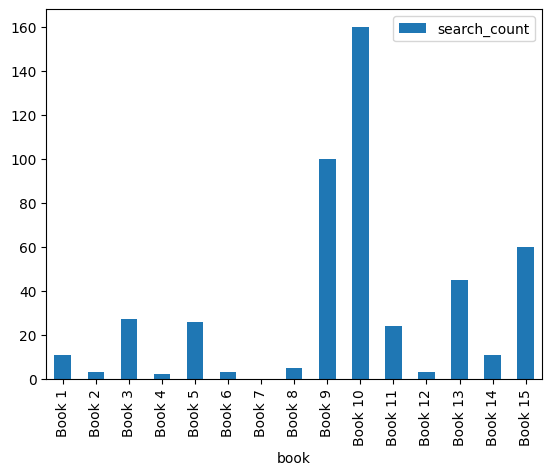

In [ ]:
search = 'napoleon'
book_df['search_count'] = book_df['word_tokenized'].apply(lambda x: x.count(search.lower()))

book_df.plot(x='book',y='search_count', kind='bar')

## Generalizing
Once I am happy with how my pipeline is functioning, I like to then try to write a function that is as general as possible. In this case, we started with a Gutenberg URL to a `txt` file, so let's take that as the starting place for our general function. Please take some time to develop a function which will return a `DataFrame` which we can use to generate a similar visualization as above from any Gutenbery URL. Be careful to note where, in the code above, some methods are specific to *War and Peace* and which are general. 

In [ ]:
def get_gutenberg_data(
    url, # the Gutenberg URL
    # you may need more arguments for your function 
    ):
    """ 
    Takes in a Gutenberg URL 
    Returns a DataFrame of relevant information
    """
    ## GET TEXT FROM URL WITH A REQUEST
    
    ## TRIM YOUR TEXT BASED ON SUBSTRINGS

    content_dict = {}
    content_list = list(re.finditer(r'YOUR REGEX HERE!!'), text)

    ## CREATE A DICTIONARY FOR THE INDEX POSITONS YOUR CONTENT
    
    ## CONVERT YOUR DICTIONARY INTO A DATAFRAME

    ## CREATE A TEXT COLUMN IN YOUR DATAFRAME

    ## CLEAN YOUR TEXT

    ## TOKENIZE (SENTENCE AND WORD LEVEL)

    ## RETURN YOUR DATAFRAME

In [ ]:
search = '' ## INPUT SEARCH TERM HERE

## ADD A COUNTS COLUMN 

## PLOT A GRAPH

## Specific Application

From *Tolstoy's Phoenix: From Method to Meaning in War and Peace* by George R. Clay (1998), page 7:
<br>
>In the most direct use of Tolstoy's technqiues, he categorizes in his own voice. Instead of "The princess smiled, thinking she know more abou the subject than Prince Vasili," he will write: "The princess smiled, *as people do* who think they know more about the subject under discussion than those they are talking with" (1:2, p.77; emphasis added). The first version expresses a private thought, but the one Tolstoy used implies (as R. F. Christian phrased it) that "there is a basic denominator of human experience" -- a sameness about our pattern of behavior, so that we all know what kind of smile it is... By writing "as people do," Tolstoy isn't telling us what this smile is like, he is assuming that we *know* what it is like: that we have seen it many times before...

Let's try to find more examples and see if they fall in line with Clay's analysis.

In [ ]:
# the phrases Clay identifies as relevent
phrases = [
    'as people do',
    'of one who',
    'peculiar to',
    'as with everyone',
    'as one who',
    'only used by persons who',
    'of a man who',
    'which a man has',
    'in the way',
    'as is usually the case',
    'such as often occurs',
    'which usually follows'
]
def printExcerpt(row):
    print(row['chapter'], row['sents'], sep='\t')
    print('\n')

In [ ]:
for phrase in phrases:
    print(phrase.upper())
    sub_df = sent_explode.loc[sent_explode['sents'].str.contains(phrase)]
    sub_df.apply(printExcerpt,axis=1)
    print('-----')

AS PEOPLE DO
Chapter 21	do you understand that in consideration of the count’s services, his request would be granted?...” the princess smiled as people do who think they know more about the subject under discussion than those they are talking with.


-----
OF ONE WHO
Chapter 6	he put on the air of one who finds it impossible to reply to such nonsense, but it would in fact have been difficult to give any other answer than the one prince andrew gave to this naïve question.


Chapter 10	“i can just imagine what a funny figure that policeman cut!” and as he waved his arms to impersonate the policeman, his portly form again shook with a deep ringing laugh, the laugh of one who always eats well and, in particular, drinks well.


Chapter 21	she had the air of one who has suddenly lost faith in the whole human race.


Chapter 113	when he had joined the freemasons he had experienced the feeling of one who confidently steps onto the smooth surface of a bog.


Chapter 150	but in spite of that sh

Great! Now we can see all of the times that Tolstoy uses these particular phrases and we can begin to see what Clay is saying. In this lines, Tolstoy is not giving us a direct characterization or description of a person or thing. Instead he is telling us about the type of person or thing it is. The next step would be then to see if there is a trend in the people or things he refers to in this manner or if this is, as Clay contends, is a general feature of Tolstoy's prose. At every step in that process, we must make sure to compare our results with Clay and Tolstoy himself. It can be easy to trick yourself into a discovery and the only way to avoid that is to have a close connection to the data itself. Always spend time to play around with your data, even after you think it's 100% clean, to see what it hides.

## Reviewing what we learned
* How to take advantage of free repositories of text like Project Gutenberg
* Taking a url to a text and reading it into our Python runtime
* Cleaning our data so that we can find some general statisics
* How to create visualizations of these statisics
* Applying simple methodologies to a complex question
* Outlining a method we could use to answer such a question

As a challenge, now that we have a good baseline for picking out the phrases Clay points us too, can you create dataframe that stores the sentence, what phrase from Clay it uses, and what chapter it is in? Be sure to start with a dictionary, as we did when we created a dataframe together and then convert it into a dataframe using `from_dict`. When you're done, you can then export it as a .csv file, so you can use it later with the method `whatever_your_df_is_called.to_csv('name_of_file.csv')`. This way you can share your work with other scholars and later can deploy it to a website or another publication. If you have trouble or just want to show off how you did it, feel free to reach out and let me know at peter.nadel@tufts.edu 

# Thanks for reading